# Analysis of lead opening events Mar 29 and Apr 15
10/20/2023


### Import packages

In [74]:
%load_ext autoreload
%autoreload 2

from common_imports import *

sys.path.append('./scripts/')
from LIB_iceage_NSIDC0611 import grab_iceage
from LIB_SIDExbuoy import open_buoy_data, calc_velocity
from LIB_plot_sat import pair_images_meta, plot_singleband_sat
from LIB_plot_VIIRS import load_VIIRS_band, get_VIIRS_geo
from LIB_plot_MODIS import load_MODISband, get_MODISgeo

font = {'size'   : 10}
FS = 10
matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Function for quickly grabbing / plotting SIC

In [48]:
def open_SIC(date, sp = 3, prod = 'sic_merged'):
    
    out = grab_SIC_MODISAMSR(date=date, 
                             file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/SIC_MODIS_AMSR2/', 
                             file_name='2021/sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc', 
                             geo_file='coordinates_npstere_1km_arctic.nc', 
                             return_vars=['lon', 'lat', prod])
    lon, lat, sic_merge = out[0], out[1], out[2]
    
    # crop to region of interest
    ai = 2000 
    af = -1200
    bi = 350
    bf = -4200
    lon_sic_c = lon[ai:af, bi:bf]
    lat_sic_c = lat[ai:af, bi:bf]
    sic_sic_c = sic_merge[ai:af, bi:bf]

    LON = lon_sic_c[::sp, ::sp]
    LAT = lat_sic_c[::sp, ::sp]
    SIC = sic_sic_c[::sp, ::sp]
    
    return LON, LAT, SIC

def plot_SIC(ax, LON, LAT, SIC):

    cmap = mpl.cm.Blues(np.linspace(0,1,20))              # cropped cmap
    cmap = mpl.colors.ListedColormap(cmap[:-7,:-1][::-1]) # cropped cmap
    ax.pcolormesh(LON, LAT, ma.masked_where(SIC>100, SIC), 
                  vmin = 85, vmax = 100, cmap=cmap, zorder=0, transform=ccrs.PlateCarree())

## Function for plotting imagery

In [49]:

    
def grab_imagery_pair(paired_images, sensor, pair = 0):
    
    ii = pair
    
    # grab metadata from current_set of paired images
    #------------------------------------------------
    # grab current_set of paired images to run through
    current_set = paired_images[np.where(paired_images[:,4]==ii)[0]]
    # start empty lists to fill with image names, paths, and dates
    IMG_filename=[]
    GEO_filename=[]
    # add data from all images in current_set to above lists
    counter = 0
    for image_meta in current_set:
        # grab date and ImageName for saving from first file in current_set
        if counter == 0:
            ImageDate = image_meta[0]
            ImageName = image_meta[3]+image_meta[2][0:22]
        IMG_filename = np.append(IMG_filename, image_meta[3]+image_meta[2])
        GEO_filename = np.append(GEO_filename, image_meta[3]+image_meta[1])
        counter+=1

    # grab data from current_set of paired images
    #--------------------------------------------
    # start empty lists to fill with imagery data and coordinates
    _image_ = []
    lat = []
    lon = []

    # for all images in current_set
    for jj in range(len(current_set)):

        # import imagery data, mask invalid values
        # and import geo data
        #-----------------------------------------
        if str(sensor) == 'MODIS':
            _level1bimage_ = load_MODISband(IMG_filename[jj], 'EV_1KM_Emissive', '31', 'radiance')
            LAT, LON = get_MODISgeo(GEO_filename[jj])
        elif str(sensor) == 'VIIRS':
            _level1bimage_ = load_VIIRS_band(IMG_filename[jj], band = 'M15')
            LAT, LON = get_VIIRS_geo(GEO_filename[jj])
        # add imagery and coordinates for this file to the lists
        #-------------------------------------------------------
        _image_.append(_level1bimage_)
        lat.append(LAT)
        lon.append(LON)

    return lat, lon, _image_

# Open buoy coordinate data

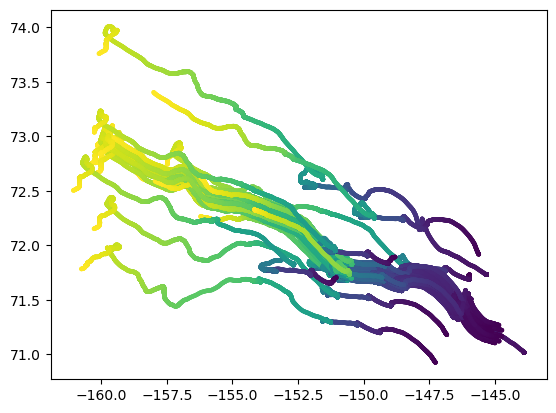

In [50]:
buoy_ds = xr.open_dataset('./data/BuoyCoordinates_cln_v0.nc')
buoy_ds.close()
# buoy_ds['time'] = pd.to_datetime(buoy_ds.time)

#=======================================================================
TI = datetime(year=2021, month=2, day=28, hour=23, minute=30)
TF = datetime(year=2021, month=5, day=31, hour=0, minute=30)
#=======================================================================
timess = pd.to_datetime(buoy_ds.sel(time=slice(TI, TF)).time.values)
buoy_time = buoy_ds.time.values
buoy_IDs = buoy_ds.buoyID.values

days_since_TI = (timess - timess[0]).total_seconds() / (60 * 60 * 24)

for buoy in buoy_ds.buoyID.values:
    plt.scatter(buoy_ds.longitude.sel(buoyID=buoy).sel(time=slice(TI, TF)), 
                buoy_ds.latitude.sel(buoyID=buoy).sel(time=slice(TI, TF)),
                c=days_since_TI, s=5)

## Open coastal open area file

In [51]:
ds_open = xr.open_dataset('./data/SBS_open_area.nc')
ds_open.close()

### Create dictionary for marker symbols

In [52]:
# marker_dict = {}

# for buoy in ['24', '45', '53']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'NW'
#     marker_dict[buoy]['shape'] = 's'
#     marker_dict[buoy]['size'] = 20
    
# for buoy in ['23', '25', '26', '29', '30', '35', '38', '40', '41', '43', '49']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'W'
#     marker_dict[buoy]['shape'] = 'v'
#     marker_dict[buoy]['size'] = 30    
    
# for buoy in ['28', '32', '33', '36', '46', '48', '50', '51']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'E'
#     marker_dict[buoy]['shape'] = 'o'
#     marker_dict[buoy]['size'] = 25 

# for buoy in ['27', '31']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'SE'
#     marker_dict[buoy]['shape'] = 'd'
#     marker_dict[buoy]['size'] = 40 

# for buoy in ['52']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'LF'
#     marker_dict[buoy]['shape'] = 'X'
#     marker_dict[buoy]['size'] = 40 

marker_dict = {}

for buoy in ['24', '53']:
    marker_dict[buoy] = {}
    marker_dict[buoy]['group'] = 'NW'
    marker_dict[buoy]['shape'] = 's'
    marker_dict[buoy]['size'] = 20
    
for buoy in ['23', '25', '26', '29', '30', '35', '38', '40', '41', '43', '49']:
    marker_dict[buoy] = {}
    marker_dict[buoy]['group'] = 'W'
    marker_dict[buoy]['shape'] = 'v'
    marker_dict[buoy]['size'] = 30    
    
for buoy in ['28', '32', '33', '36', '46', '48', '50', '51','45','27']:
    marker_dict[buoy] = {}
    marker_dict[buoy]['group'] = 'E'
    marker_dict[buoy]['shape'] = 'o'
    marker_dict[buoy]['size'] = 25 

for buoy in ['31','52']:
    marker_dict[buoy] = {}
    marker_dict[buoy]['group'] = 'SE'
    marker_dict[buoy]['shape'] = 'd'
    marker_dict[buoy]['size'] = 40 

# for buoy in ['52']:
#     marker_dict[buoy] = {}
#     marker_dict[buoy]['group'] = 'LF'
#     marker_dict[buoy]['shape'] = 'X'
#     marker_dict[buoy]['size'] = 40 

# plot buoy speeds over long sequence relative to ice conditions

time range: 2021-03-27 16:00:00 ---  2021-04-03 08:00:00


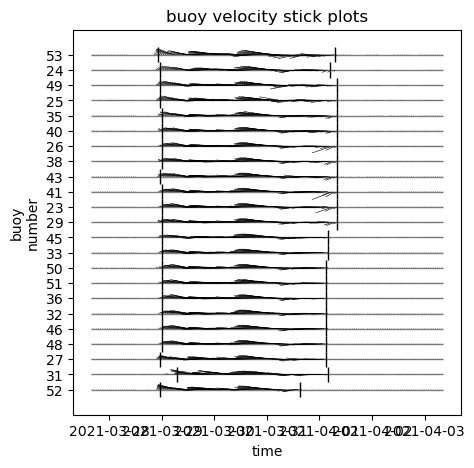

In [53]:
#===========================================================
# start_date = datetime(year = 2021, month = 3, day = 27, hour = 23, minute = 30)
# end_date = datetime(year = 2021, month = 4, day = 3, hour = 0, minute = 30)
# dat_lab = 'Mar29'

start_date = datetime(year = 2021, month = 3, day = 27, hour = 15, minute = 30)
end_date = datetime(year = 2021, month = 4, day = 3, hour = 8, minute = 30)
dat_lab = 'Mar29'


# start_date = datetime(year = 2021, month = 4, day = 14, hour = 23, minute=30)
# end_date = datetime(year = 2021, month = 4, day = 18, hour = 0, minute=30)
# dat_lab = 'Apr15'


# velocity component flag (speeds over this replaced with nans as nonphysical)
velflag = 60*units('cm')/units('s')

STEP = 2
#===========================================================

# buoys west of lead, but further west or north of lead than others
buoys_NW = ['24','53']
# buoys west of lead
buoys_W = ['29', '23', '41', '43', '38', '26', '40', '35', '25', '49']#'30',
# buoys east of lead
buoys_E = ['27','48', '46', '32', '36', '51', '50',  '33','45',]#'28',
# south and far east buoys that open later as different lead opens
buoys_SE = ['52','31']


#===========================================================
ordered_IDs = buoys_SE + buoys_E + buoys_W + buoys_NW
#===========================================================


fig, ax = plt.subplots(figsize = (5,5))

first_times = np.array([])
final_times = np.array([])

all_speeds = np.array([])
all_us = np.array([])
all_vs = np.array([])
all_dirs = np.array([])

for bb, buoy in enumerate(ordered_IDs):
    
    # grab buoy data
    #---------------
    lon_track = buoy_ds.longitude.sel(time=slice(start_date,end_date)).sel(buoyID = buoy).values
    lat_track = buoy_ds.latitude.sel(time=slice(start_date,end_date)).sel(buoyID = buoy).values
    time_track = pd.to_datetime(buoy_ds.time.sel(time=slice(start_date,end_date)).values)

    # calculate velocity
    #-------------------
    u, v, time, dx, dy, dist = calc_velocity(lon_track = lon_track, lat_track = lat_track, 
                                                 time_track = time_track, step = STEP)
    
    # ice drift direction
    ice_dir = metpy.calc.wind_direction(u, v, convention='from')
    
    # flag unphysical velocities
    v_flag = np.sqrt(u**2+v**2) > velflag
    u[v_flag] = np.nan
    v[v_flag] = np.nan
    ice_dir[v_flag] = np.nan
    
    # save all data
    all_speeds = np.append(all_speeds, np.sqrt(u**2+v**2))
    all_us = np.append(all_us, u)
    all_vs = np.append(all_vs, v)
    all_dirs = np.append(all_dirs, ice_dir)
        
    # find first / last times large velocities occur over time window
    first_vel = time[np.sqrt(u**2+v**2) > 5 * units('cm/s')][0]
    final_vel = time[np.sqrt(u**2+v**2) > 5 * units('cm/s')][-1]
    first_times = np.append(first_times, first_vel)
    final_times = np.append(final_times, final_vel)
    
    # plotting
    #---------
    # stick plot
    ax.hlines(bb, start_date, end_date, colors='k', linewidths=1, alpha=0.5, zorder=-1)
    ax.quiver(time, bb+np.zeros(len(time)), u, v, color='k', scale=400, width=0.0015, headwidth=0)
    
    # first/last velocities
    ax.vlines(first_vel, bb-0.5, bb+0.5, colors='k', linewidths=1, alpha=1, zorder=-1)
    ax.vlines(final_vel, bb-0.5, bb+0.5, colors='k', linewidths=1, alpha=1, zorder=-1)
    
    
ax.set_ylabel('buoy\nnumber')
ax.set_xlabel('time')
ax.set_title('buoy velocity stick plots')
ax.set_yticks(np.arange(len(ordered_IDs)))
ax.set_yticklabels(ordered_IDs)


print(f'time range: {time[0]} ---  {time[-1]}')

# regrid buoy data for meshgridding
#----------------------------------
time_grid, num_grid = np.meshgrid(time, np.arange(len(buoy_IDs)))
speeds_regrid = np.reshape(all_speeds, ( len(buoy_IDs), int(len(all_speeds)/len(buoy_IDs))))
us_regrid = np.reshape(all_us, ( len(buoy_IDs), int(len(all_speeds)/len(buoy_IDs))))
vs_regrid = np.reshape(all_vs, ( len(buoy_IDs), int(len(all_speeds)/len(buoy_IDs))))
dirs_regrid = np.reshape(all_dirs, ( len(buoy_IDs), int(len(all_speeds)/len(buoy_IDs))))
speed_regrid = np.sqrt(us_regrid**2+vs_regrid**2).magnitude

### Set x-label formatting

In [54]:
XMIN = time[0]
XMAX = time[-1]
print(f'xmin: {XMIN}  xmax: {XMAX}')
if str(dat_lab) == 'Apr15':
    dates_to_label = time[12::12]
    MOD = 1
elif str(dat_lab) == 'Mar29':
    dates_to_label = time[8::12]
    MOD = 1
    
# x = lambda date : pd.to_datetime(date).strftime('%d %b')
x = lambda date : f"{int(pd.to_datetime(date).strftime('%d'))}/{int(pd.to_datetime(date).strftime('%m'))}"
# x = lambda date : f"{pd.to_datetime(date).strftime('%d')}\n{pd.to_datetime(date).strftime('%b')}"
date_labels = [x(date) for dd, date in enumerate(dates_to_label)]

for dd, date in enumerate(date_labels):
    if dd%2 == MOD:
        date_labels[dd] = ''
for dd, date in enumerate(dates_to_label):
    print(f'{date} --> {date_labels[dd]}')

xmin: 2021-03-27 16:00:00  xmax: 2021-04-03 08:00:00
2021-03-28 00:00:00 --> 28/3
2021-03-28 12:00:00 --> 
2021-03-29 00:00:00 --> 29/3
2021-03-29 12:00:00 --> 
2021-03-30 00:00:00 --> 30/3
2021-03-30 12:00:00 --> 
2021-03-31 00:00:00 --> 31/3
2021-03-31 12:00:00 --> 
2021-04-01 00:00:00 --> 1/4
2021-04-01 12:00:00 --> 
2021-04-02 00:00:00 --> 2/4
2021-04-02 12:00:00 --> 
2021-04-03 00:00:00 --> 3/4


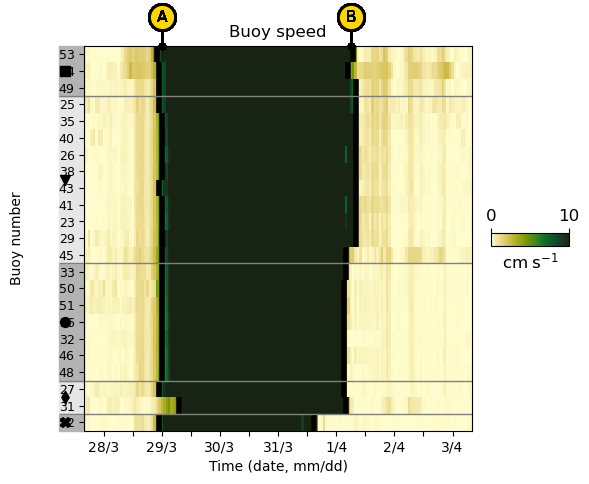

In [55]:


fig, ax = plt.subplots(figsize=(5,5))
# ax.set_facecolor('lightgray')
# ax.set_title('buoy speed')

    
#////////////////////
# plot colormesh ///
#/////////////////////////////////////////////////////////////////////////////////////

# CMAP = 'Oranges'
CMAP = cmocean.cm.speed#cmocean.tools.crop_by_percent(cmocean.cm.thermal, 35, which='min', N=None)

mesh=ax.pcolormesh(time_grid, num_grid, speed_regrid, vmin=0,vmax=10, cmap=CMAP)

ax.set_title('Buoy speed')
# ax.text(0.15,1.05,'Event 1 buoy speed', transform = ax.transAxes)

# add_colorbar(fig, ax, [mesh], cb_placement='top', cb_width=0.025, 
#              cb_length_fraction=[0.7, 1], cb_pad=0.025, cb_ticks=[0,20], 
#              cb_ticklabels='auto', cb_extend='neither', cb_label='Buoy speed\n$(\mathrm{cm\;{s}^{-1}})$', 
#              labelpad = -5, cb_label_placement='auto', cb_tick_placement='auto',
#              cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# ax.text(XMAX+timedelta(hours=27), 10, 'Buoy\nspeed\n$(\mathrm{cm\;{s}^{-1}})$', 
#         horizontalalignment='center',clip_on=False)
# add_colorbar(fig, ax, [mesh], cb_placement='right', cb_width=0.025, 
#              cb_length_fraction=[0.3,0.7], cb_pad=0.05, cb_ticks=[0,30], 
#              cb_ticklabels='auto', cb_extend='neither',  
#              labelpad=-10, cb_label_placement='auto', cb_tick_placement='auto',
#              cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


add_colorbar(fig, ax, [mesh], cb_placement='top', cb_width=0.025, 
             cb_length_fraction=[1.05, 1.25], cb_pad=-0.4, cb_ticks=[0,10,20,30], 
             cb_ticklabels='auto', cb_label = '$\mathrm{cm\;{s}^{-1}}$',
             labelpad='auto', cb_label_placement='bottom', cb_tick_placement='auto',
             cb_labelsize=12, draw_edges=False, edge_params=['k', 2])

# mesh=ax.pcolormesh(time_grid, num_grid, us_regrid, vmin=-20,vmax=20, cmap='RdBu_r')
# mesh=ax.pcolormesh(time_grid, num_grid, ma.masked_where(speed_regrid < 5*units('cm/s'), dirs_regrid), 
#                    vmin=0,vmax=360, cmap='twilight')


#///////////
# ticks ///
#/////////////////////////////////////////////////////////////////////////////////////
# x ticks
#--------
ax.set_xticks(dates_to_label)
ax.set_xticklabels(date_labels)
ax.set_xlim(XMIN, XMAX)
ax.set_xlabel('Time (date, mm/dd)')

# y ticks
#--------
ax.set_ylim(-0.5,22.5)
ax.set_yticks(np.arange(len(ordered_IDs)))
ax.set_yticklabels(ordered_IDs,fontsize=FS-1);
ax.set_ylabel('Buoy number', rotation=90, labelpad=30, verticalalignment='center')


#////////////////////////
# plot group markers ///
#/////////////////////////////////////////////////////////////////////////////////////
marker_color = 'k'

BF = 22.5
B4 = 19.5
B3 = 9.5
B2 = 2.5
B1 = 0.5
B0 = -0.5

C1 = [0.7,0.7,0.7]
C2 = [0.9,0.9,0.9]

if str(dat_lab) == 'Apr15':
    DT = timedelta(hours=16)
elif str(dat_lab) == 'Mar29':
    DT = timedelta(hours=10.5)
ax.fill_between([time[0]-DT, time[0]], [B0, B0], [B1, B1], color=C1, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B1, B1], [B2, B2], color=C2, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B2, B2], [B3, B3], color=C1, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B3, B3], [B4, B4], color=C2, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B4, B4], [BF, BF], color=C1, clip_on=False)

for bound in [B1, B2, B3, B4]:
    ax.hlines(bound, time[0]-DT, time[-1], lw = 1, colors='gray', linestyles='solid', clip_on=False)

if str(dat_lab) == 'Apr15':
    DT = timedelta(hours=13)
elif str(dat_lab) == 'Mar29':
    DT = timedelta(hours=8)
ax.scatter(time[0]-DT, np.mean([B4,BF]), marker='s',c=marker_color,  s=50, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B3,B4]), marker='v',c=marker_color,  s=50, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B2,B3]), marker='o',c=marker_color,  s=50, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B1,B2]), marker='d',c=marker_color,  s=40, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B0,B1]), marker='X',c=marker_color,  s=50, clip_on=False)



#//////////////////////////
# plot start/end times ///
#/////////////////////////////////////////////////////////////////////////////////////
for bb in range(len(ordered_IDs)):
    ax.vlines(first_times[bb], bb-0.5, bb+0.5, colors='k', linewidths=4, alpha=1, zorder=1)
    ax.vlines(final_times[bb], bb-0.5, bb+0.5, colors='k', linewidths=4, alpha=1, zorder=1)


#///////////////////////////
# label opening/closing ///
#/////////////////////////////////////////////////////////////////////////////////////
for bb in range(len(ordered_IDs)):
    if str(dat_lab) == 'Apr15':
        START =datetime(2021,4,16,2)
        END =datetime(2021,4,16,15)
    elif str(dat_lab) == 'Mar29':
        START = datetime(2021,3,29,0)
        END = datetime(2021,4,1,6)

    labels = ['A', 'B']
    for ll, loc in enumerate([START, END]):
        outline_color = 'k'
        inner_color = 'gold'
        ax.axvline(x = loc, ymin=1, ymax=1.075, lw=2, c=outline_color, linestyle = 'solid', clip_on = False, zorder=1)
        ax.scatter(loc, ax.get_ylim()[-1]*1.075, c=inner_color, lw=2, marker='o', edgecolor=outline_color,  s=350, clip_on = False, zorder=2)
        ax.scatter(loc, ax.get_ylim()[-1], c=outline_color, marker='o', edgecolor=outline_color,  s=20, clip_on = False, zorder=3)
        ax.text(loc, ax.get_ylim()[-1]*1.075, labels[ll], horizontalalignment='center',  verticalalignment='center', 
                   c='k', fontsize=FS+1, clip_on = False, zorder=3)
        
    
# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigF/CASE{dat_lab}_BuoySpeed.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=True, bbox_inches="tight", pad_inches = 0.1, dpi=300)

### plot winds

In [56]:
ds = xr.open_dataset('./data/SBS_ERA5_hourly.nc')
ds.close()
wind_u = ds.u.sel(time=slice(time[0], time[-1])).values
wind_v = ds.v.sel(time=slice(time[0], time[-1])).values
msl = ds.msl.sel(time=slice(time[0], time[-1])).values
wind_speed = np.sqrt(wind_u**2+wind_v**2)
wind_dir = ds.wind_dir.sel(time=slice(time[0], time[-1])).values

time_adjust = np.append(time - timedelta(minutes=30), time[-1] + timedelta(minutes=30))
heights = np.array([0,1])
time_grid2, height_grid2 = np.meshgrid(time_adjust, heights)

## V1

[]

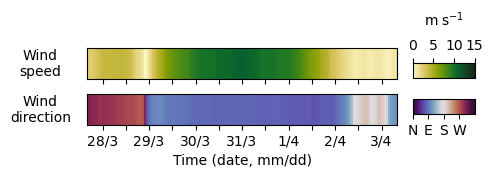

In [57]:
fig, axs = plt.subplots(2,1,figsize=(4,1))
plt.subplots_adjust(hspace=0.5)


#////////////////////
# wind direction ///
#/////////////////////////////////////////////////////////////////////////////////////
LABEL = 'Dir'
axs[1].set_ylabel('Wind\ndirection', rotation=0, labelpad=30, verticalalignment='center')

winds = axs[1].pcolormesh(time_grid2, height_grid2, [wind_dir], vmin=0,vmax=360, cmap='twilight_shifted')

add_colorbar(fig, axs[1], [winds], cb_placement='top', cb_width=0.15, 
             cb_length_fraction=[1.05, 1.25], cb_pad=-0.2, cb_ticks=[0,90,180,270], 
             cb_ticklabels=['N','E','S','W'], cb_label = '',
             labelpad='auto', cb_label_placement='bottom', cb_tick_placement='bottom',
             cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

axs[0].set_xlim(XMIN, XMAX)
axs[0].set_xticks(dates_to_label)
axs[0].set_xticklabels(['']*len(dates_to_label),)
axs[0].set_yticks([])
#/////////////////////////////////////////////////////////////////////////////////////


#////////////////
# wind speed ///
#/////////////////////////////////////////////////////////////////////////////////////
LABEL = 'Speed'
axs[0].set_ylabel('Wind\nspeed',  rotation=0, labelpad=30, verticalalignment='center')

winds = axs[0].pcolormesh(time_grid2[0,:], height_grid2, [wind_speed], vmin=0,vmax=15, cmap=cmocean.cm.speed)

add_colorbar(fig, axs[0], [winds], cb_placement='top', cb_width=0.15, 
             cb_length_fraction=[1.05, 1.25], cb_pad=-0.3, cb_ticks=[0,5,10,15],
             cb_extend='neither', cb_label = '$\mathrm{m\;{s}^{-1}}$',
             labelpad=10, cb_label_placement='top', cb_tick_placement='auto',
             cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

axs[1].set_xlim(XMIN, XMAX)
axs[1].set_xticks(dates_to_label)
axs[1].set_xticklabels(date_labels)
axs[1].set_xlabel('Time (date, mm/dd)',)
axs[1].set_yticks([])
#/////////////////////////////////////////////////////////////////////////////////////

# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigF/CASE{dat_lab}_WindSpeedDirection.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=True, bbox_inches="tight", pad_inches = 0.1, dpi=300)

## V2

Text(0, 0.5, 'Wind\nspeed')

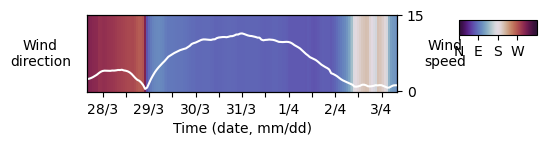

In [58]:
fig, ax = plt.subplots(figsize=(4,1))


#////////////////////
# wind direction ///
#/////////////////////////////////////////////////////////////////////////////////////
LABEL = 'Dir'
ax.set_ylabel('Wind\ndirection', rotation=0, labelpad=30, verticalalignment='center')

winds = ax.pcolormesh(time_grid2, height_grid2, [wind_dir], vmin=0,vmax=360, cmap='twilight_shifted')

add_colorbar(fig, ax, [winds], cb_placement='top', cb_width=0.15, 
             cb_length_fraction=[1.2, 1.45], cb_pad=-0.2, cb_ticks=[0,90,180,270], 
             cb_ticklabels=['N','E','S','W'], cb_label = '',
             labelpad='auto', cb_label_placement='bottom', cb_tick_placement='bottom',
             cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


ax.set_xlim(XMIN, XMAX)
ax.set_xticks(dates_to_label)
ax.set_xticklabels(date_labels)
ax.set_xlabel('Time (date, mm/dd)')

ax.set_yticks([])



ax2 = ax.twinx()

ax2.plot(time, wind_speed, c='white')

ax2.set_yticks([0,15])
ax2.set_yticklabels([0,15])
ax2.set_ylabel('Wind\nspeed', rotation=0, labelpad=15, verticalalignment='center')


#/////////////////////////////////////////////////////////////////////////////////////

# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigF/CASE{dat_lab}_WindSpeedDirection_V2.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=True, bbox_inches="tight", pad_inches = 0.1, dpi=300)

## Find local winds for wind factor calculations
At each time for each buoy, grab wind from nearest ERA5 grid point.
Save to grid matching buoy speed grid array.

In [59]:
from scipy.interpolate import RegularGridInterpolator

def interpolate_geo_data(interp_lon = 100, interp_lat = 70, 
                         lons = np.array([]), lats = np.array([]),
                         data1 = np.array([]), data2 = np.array([]), 
                         buffer_lon = 2, buffer_lat = 1, show_map = False):

    """This uses scipy RegularGridInterpolator so does not take into account true distances 
    between regularly gridded data points, 
    but should be close enough!
    lons: 1D lon array (Mx1)
    lats: 1D lat array (Nx1)
    data: 2D data array (MxN)
    """
    
    X, Y = interp_lon, interp_lat
    
    # find smaller grid around point of interest
    #-------------------------------------------
    oo = np.where(np.abs(lons-interp_lon) == np.min(np.abs(lons-interp_lon)))[0][0]
    aa = np.where(np.abs(lats-interp_lat) == np.min(np.abs(lats-interp_lat)))[0][0]

    # name as x,y coordinates and create grid
    x = lons[oo-buffer_lon:oo+buffer_lon+1].astype(np.float64)
    y = lats[aa-buffer_lat:aa+buffer_lat+1].astype(np.float64)
    xg, yg = np.meshgrid(x, y, indexing='ij')

    # create interpolation function and interpolate data at desired point
    d1 = data1[oo-buffer_lon:oo+buffer_lon+1, aa-buffer_lat:aa+buffer_lat+1].astype(np.float64)
    interp1 = RegularGridInterpolator((x, y), d1, bounds_error=False, fill_value=None)
    interp_val1 = interp1((X, Y))
    
    
    if show_map:
        # create figure in NorthPolarStereo projection
        #---------------------------------------------
        map_projection = ccrs.NorthPolarStereo(central_longitude=210)
        lat_range = [interp_lat-1.25, interp_lat+1.25]
        lon_range = [interp_lon-3, interp_lon+3]
        fig, ax = plt.subplots(subplot_kw=dict(projection=map_projection), figsize=(4,4))

        # set map extent, add grid and geo features
        #------------------------------------------
        ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
        ax.set_aspect('equal')
        add_coast(ax, scale='10m', color='gray', linewidth=0.5, alpha=1, zorder=17)
        add_grid(ax, lats=np.arange(70,90,5), lons=np.arange(100,300,20), linewidth=1, color='gray', alpha=0.3, zorder=18)

        normalize = matplotlib.colors.Normalize(vmin=-10, vmax=10)
        out = ax.pcolormesh(xg, yg, d1, cmap='RdBu_r', norm=normalize, transform=ccrs.PlateCarree())
        ax.scatter(xg, yg, s = 1, c='gray', transform=ccrs.PlateCarree())
        ax.scatter(X, Y, c=interp_val1, edgecolor='k', cmap = 'RdBu_r', norm=normalize, transform=ccrs.PlateCarree())
        plt.colorbar(out)
    
    # create 2nd if second data grid provided
    if len(data2) == 0:
        return interp_val1
    
    else:
        d2 = data2[oo-buffer_lon:oo+buffer_lon+1, aa-buffer_lat:aa+buffer_lat+1].astype(np.float64)
        interp2 = RegularGridInterpolator((x, y), d2,bounds_error=False, fill_value=None)
        interp_val2 = interp2((X, Y))

        return interp_val1, interp_val2

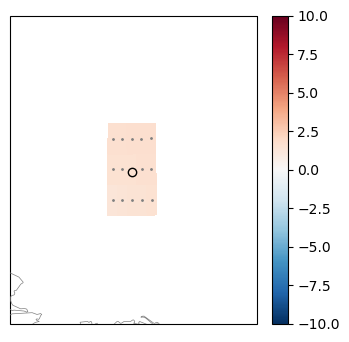

In [60]:

# open ERA5 data
#---------------
# ds_era = xr.open_dataset('/Users/mackenziejewell/Desktop/ERA5_2021.nc')
ds_era = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc')
ds_era.close()
ERA_lons = ds_era.longitude.values
ERA_lats = ds_era.latitude.values
ERA_times = ds_era.time.values


# grids to store wind data interpolated to buoy positions
#-------------------------------------------------------
u10_regrid = np.zeros_like(speed_regrid)
v10_regrid = np.zeros_like(speed_regrid)
wind_regrid = np.zeros_like(speed_regrid)
wdir_regrid = np.zeros_like(speed_regrid)

    

for bb, buoy in enumerate(ordered_IDs):

    buoy_times = buoy_ds.sel(time=slice(start_date, end_date)).time.values[1:-1][::2]
    buoy_lons = buoy_ds.longitude.sel(time=slice(start_date, end_date)).sel(buoyID = buoy).values[1:-1][::2]
    buoy_lats = buoy_ds.latitude.sel(time=slice(start_date, end_date)).sel(buoyID = buoy).values[1:-1][::2]

    for ii in range(len(buoy_times)):

        # grab data from specific time
        #-----------------------------
        tim = buoy_times[ii]
        tt = np.where(ERA_times == tim)[0][0]
        spec_ds = ds_era.sel(time = ds_era.time[tt])
        lon = buoy_lons[ii]
        lat = buoy_lats[ii]

        if bb == 11 and ii == 0:
            show_map = True
        else:
            show_map = False
            
        if spec_ds.u10.dims == ('latitude', 'longitude'):
            all_u10 = np.transpose(spec_ds.u10.values)
            all_v10 = np.transpose(spec_ds.v10.values)
            all_msl = np.transpose(spec_ds.msl.values)
        else:
            all_u10 = spec_ds.u10.values
            all_v10 = spec_ds.v10.values
            all_msl = spec_ds.msl.values
            
        if ERA_lats[0] > ERA_lats[1]:
            ERA_lats_ = ERA_lats[::-1]
            all_u10_ = all_u10[:,::-1]
            all_v10_ = all_v10[:,::-1]
        else:
            ERA_lats_ = ERA_lats
            all_u10_ = all_u10
            all_v10_ = all_v10
            
        local_u10, local_v10 = interpolate_geo_data(interp_lon = lon, interp_lat = lat, 
                                                    lons = ERA_lons, lats = ERA_lats_, 
                                                    data1 = all_u10_, 
                                                    data2 = all_v10_, 
                                                    show_map=show_map)
        
        local_ws = np.sqrt(local_u10**2+local_v10**2)
        local_wd = metpy.calc.wind_direction(local_u10*units('m/s'), local_v10*units('m/s'), convention='from').magnitude
        
        u10_regrid[bb, ii] = local_u10
        v10_regrid[bb, ii] = local_v10
        wind_regrid[bb, ii] = local_ws
        wdir_regrid[bb, ii] = local_wd
        

### V2

In [61]:
def add_windDir_key(ax):
    
    phis   = np.linspace(0,1,50) 
    thetas = np.linspace(0,2.01*np.pi,201)
    X,Y = np.meshgrid(thetas,phis)

    ax.pcolormesh(X,Y,X, vmin=0,vmax=2*np.pi, cmap=mpl.cm.twilight_shifted)
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")

    ax.set_rticks([])
    ax.set_rlim(0,1)
    # ax.grid(linewidth=0.5, zorder=-10, c='k')

    # xticks = np.arange(0,2*np.pi,np.pi/4)
    # xticklabels = ['N', 'NE',  'E',  'SE', 'S',  'SW',  'W',  'NW', ]
    # yy = [1.2, 1.3, 1.2, 1.3, 1.25, 1.3, 1.25, 1.3]

    xticks = np.arange(0,2*np.pi,np.pi/2)
    xticklabels = ['N', 'E','S', 'W']
    yy = 1.35*np.array([1.2, 1.2, 1.3, 1.25])

    ax.set_xticks(xticks)
    ax.set_xticklabels([])
    for tt in range(len(xticks)):
        ax.text(xticks[tt], yy[tt], xticklabels[tt], ha='center', va='center', 
                transform=ax.transData, rotation=0)


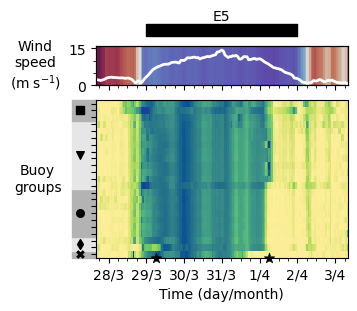

In [69]:


fig, axs = plt.subplots(2, 1, sharex=True, squeeze=True, 
                       gridspec_kw = {'height_ratios':[1,4]}, figsize=(3.25,2.75))

# fig, ax = plt.subplots(figsize=(7,5))
# ax.set_facecolor('lightgray')
# ax.set_title('buoy speed')



ax = axs[0]

#////////////////////
# wind direction ///
#/////////////////////////////////////////////////////////////////////////////////////

# plot params
#------------
if str(dat_lab) == 'Mar29':
    ax.set_ylabel('Wind\nspeed\n($\mathrm{m\;s^{-1}}$)', rotation=0, labelpad=40, verticalalignment='center')
#     ax.set_ylabel('Sea level\npressure\n(hPa)', rotation=0, labelpad=60, verticalalignment='center')
else:
    ax.set_ylabel(' ', rotation=0, labelpad=20, verticalalignment='center')
ax.set_xlim(XMIN, XMAX)
ax.xaxis.set_major_locator(plt.MultipleLocator(24))
ax.xaxis.set_minor_locator(plt.MultipleLocator(6))

ax.set_yticks([])
ax.set_ylim(0,32)


mean_u10 = np.mean(u10_regrid, axis=0)
mean_v10 = np.mean(v10_regrid, axis=0)
dir_mean = metpy.calc.wind_direction(mean_u10*units('m/s'), mean_v10*units('m/s'), convention='from').magnitude


#------------------
# direction = dir_mean # local
# direction = wind_dir  # SBS region
direction = wdir_regrid[ordered_IDs.index('23'),:] # winds over buoy 23, near buoy array center
#------------------

winds = ax.pcolormesh(time_grid2, height_grid2*32, [direction],
                      vmin=0,vmax=360, cmap='twilight_shifted')

if str(dat_lab) == 'Apr15':
    ax.text(1.2,1.7, 'Wind\ndirection', horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    add_windDir_key(fig.add_axes([1, 0.75, 0.1, 0.1], polar=True))


# label event
#------------
text_y = 1.65
event_y1 = 1.55
event_y0 = 1.25
open_y1 = 1.35
open_y0 = 1.1
    
if str(dat_lab) == 'Mar29':
    ei = datetime(year = 2021, month=3, day=29, hour=0)
    ef = datetime(year = 2021, month=4, day=2, hour=0)
    ax.fill_between([ei, ef],  ax.get_ylim()[-1]*event_y0,ax.get_ylim()[-1]*event_y1,
                facecolor='k', edgecolor='k',alpha=1, zorder=-1, clip_on=False)
    ax.text(ei+(ef-ei)/2, ax.get_ylim()[-1]*text_y, f'E5', 
            color='k',  horizontalalignment='center', clip_on=False)

if str(dat_lab) == 'Apr15':
    ei = datetime(year = 2021, month=4, day=16, hour=0)
    ef = datetime(year = 2021, month=4, day=17, hour=0)
    ax.fill_between([ei, ef],  ax.get_ylim()[-1]*event_y0,ax.get_ylim()[-1]*event_y1,
                    facecolor='k', edgecolor='k',alpha=1, zorder=-1, clip_on=False)
    ax.text(ei+(ef-ei)/2, ax.get_ylim()[-1]*text_y, f'E7', 
            color='k',  horizontalalignment='center', clip_on=False)

# wind speed
#------------
ax2 = ax.twinx()

#------------------
# speed = np.mean(wind_regrid, axis=0) # local
# speed = wind_speed # SBS region
speed = wind_regrid[ordered_IDs.index('23'),:] # winds over buoy 23, near buoy array center
#------------------

ax2.plot(time, speed, c='white', lw=2)
ax2.set_ylim(0,16)
ax2.yaxis.set_major_locator(plt.MultipleLocator(15))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(5))


# ax2.plot(time, msl, c='white', lw=2)
# ax2.set_ylim(1013,1037)
# ax2.yaxis.set_major_locator(plt.MultipleLocator(10))
# ax2.yaxis.set_minor_locator(plt.MultipleLocator(5))

ax2.yaxis.tick_left()
#/////////////////////////////////////////////////////////////////////////////////////







ax = axs[1]
    
#////////////////////
# plot colormesh ///
#/////////////////////////////////////////////////////////////////////////////////////
CMAP = cmocean.tools.crop_by_percent(cmocean.cm.haline_r, 15, which='max', N=None)
mesh = ax.pcolormesh(time_grid, num_grid, speed_regrid/wind_regrid, vmin=0,vmax=3, cmap=CMAP)


if str(dat_lab) == 'Apr15':
    ax.text(XMAX+timedelta(hours=14), 0.65*ax.get_ylim()[1], r'$\mathrm{\frac{u_{ice}}{u_{wind}}}$', 
        horizontalalignment='center',fontsize=FS+7, clip_on=False)
#     ax.text(XMAX+timedelta(hours=40), 0.625*ax.get_ylim()[1], '(%)', 
#             horizontalalignment='center',clip_on=False)
    add_colorbar(fig, ax, [mesh], cb_placement='top', cb_width=0.03, 
             cb_length_fraction=[1.1, 1.3], cb_pad=-0.275, cb_ticks=[0,3], 
             cb_ticklabels=['0%', '3%'], cb_label = '',#'$\mathrm{cm\;{s}^{-1}}$',
             labelpad='auto', cb_label_placement='bottom', cb_tick_placement='bottom',
             cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

# x ticks
#--------
ax.set_xticks(dates_to_label)
ax.set_xticklabels(date_labels)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1/4))

# axT = ax.twiny()
# axT.set_xlim(XMIN, XMAX)
# axT.xaxis.set_major_locator(plt.MultipleLocator(1))
# axT.xaxis.set_minor_locator(plt.MultipleLocator(1/4))
# axT.tick_params(direction = 'in', which='both')
# axT.set_xticklabels([])

# ax.tick_params(axis="x", which='both', direction='in', bottom=True, top=True, labelbottom=True, labeltop=False)

# ax.tick_params(axis="x", which='both', direction='out', bottom=True, top=False, labelbottom=True, labeltop=False)
# ax.tick_params(axis="x", which='both', direction='in', bottom=False, top=True, labelbottom=False, labeltop=False)
ax.set_xlim(XMIN, XMAX)
ax.set_xlabel('Time (day/month)')

# y ticks
#--------
ax.set_ylim(-0.5,22.5)
ax.set_yticks(np.arange(len(ordered_IDs)))
ax.set_yticklabels(['']*len(ordered_IDs))
if str(dat_lab) == 'Mar29':
    ax.set_ylabel('Buoy\ngroups',rotation=0, labelpad=35, verticalalignment='center')
#/////////////////////////////////////////////////////////////////////////////////////



#////////////////////////
# plot group markers ///
#/////////////////////////////////////////////////////////////////////////////////////
marker_color = 'k'

BF = 22.5
B4 = 19.5
B3 = 9.5
B2 = 2.5
B1 = 0.5
B0 = -0.5

C1 = [0.7,0.7,0.7]
C2 = [0.9,0.9,0.9]


if str(dat_lab) == 'Mar29':
    DT = timedelta(hours=15)
else:
    DT = timedelta(hours=7.5)
ax.fill_between([time[0]-DT, time[0]], [B0, B0], [B1, B1], color=C1, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B1, B1], [B2, B2], color=C2, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B2, B2], [B3, B3], color=C1, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B3, B3], [B4, B4], color=C2, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B4, B4], [BF, BF], color=C1, clip_on=False)

# for bound in [B1, B2, B3, B4]:
#     ax.hlines(bound, time[0]-DT, time[-1], lw = 1, colors='gray', linestyles='solid', clip_on=False)

if str(dat_lab) == 'Mar29':
    DT = timedelta(hours=10)
else:
    DT = timedelta(hours=5)
ax.scatter(time[0]-DT, np.mean([B4,BF]), marker='s',c=marker_color,  s=26, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B3,B4]), marker='v',c=marker_color,  s=30, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B2,B3]), marker='o',c=marker_color,  s=30, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B1,B2]), marker='d',c=marker_color,  s=25, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B0,B1]), marker='X',c=marker_color,  s=40, clip_on=False, lw=0,)

    
    
#///////////////////////////
# label opening/closing ///
#/////////////////////////////////////////////////////////////////////////////////////

if str(dat_lab) == 'Apr15':
    START = datetime(2021,4,16,6)
    END = datetime(2021,4,17,0)
    labels = ['C', 'D']
elif str(dat_lab) == 'Mar29':
    START = datetime(2021,3,29,6)
    END = datetime(2021,4,1,6)
    labels = ['A', 'B']

markers = ['D', '*']
sizes = [35,80]
for ll, loc in enumerate([START, END]):
    ax.scatter(loc, ax.get_ylim()[0],  marker='*', facecolor='k', edgecolor='k',  
               lw = 0.5, s=60, clip_on = False, zorder=4)
#     ax.text(loc, ax.get_ylim()[0]-0.1, labels[ll], horizontalalignment='center',  verticalalignment='center', 
#             c='k', fontsize=FS-1, clip_on = False, zorder=5)
    
    
# if str(dat_lab) == 'Apr15':
#     START = datetime(2021,4,16,6)
#     END = datetime(2021,4,17,0)
#     labels = ['c', 'd']
# elif str(dat_lab) == 'Mar29':
#     START = datetime(2021,3,29,6)
#     END = datetime(2021,4,1,6)
#     labels = ['a', 'b']

# sizes = [35,80]
# for ll, loc in enumerate([START, END]):

# #     Y = -0.5
# #         Y = 0.99*ax.get_ylim()[-1]
# #     ax.scatter(loc, Y,  marker='o', facecolor='lightgray', edgecolor='k',  
# #                lw = 0.5, s=130, clip_on = False, zorder=4)
# #     ax.text(loc, Y, labels[ll], horizontalalignment='center',  verticalalignment='center', 
# #             c='k',  clip_on = False, zorder=5)


# #         ax.scatter(loc, -0.5,  marker=markers[ll], facecolor='lightgray', edgecolor='k',  
# #                    lw = 0.5, s=sizes[ll], clip_on = False, zorder=4)

# #     ax.vlines(loc, ax.get_ylim()[0], ax.get_ylim()[-1], 
# #               lw=1, colors='white', linestyles= 'solid', zorder=3)
# #     ax.vlines(loc, ax.get_ylim()[0], ax.get_ylim()[-1], 
# #               lw=2, colors='k', linestyles= 'solid',  zorder=2)

#     ax2.scatter(loc, ax2.get_ylim()[-1],  marker='o', facecolor='lightgray', edgecolor='k',  
#                lw = 0.5, s=150, clip_on = False, zorder=4)
#     ax2.text(loc, ax2.get_ylim()[-1], labels[ll], horizontalalignment='center',  verticalalignment='center', 
#             c='k', clip_on = False, zorder=5)
                  
            
# ax = ax2
# if str(dat_lab) == 'Apr15':
#     START = datetime(2021,4,16,6)
#     END = datetime(2021,4,17,0)
# elif str(dat_lab) == 'Mar29':
#     START = datetime(2021,3,29,6)
#     END = datetime(2021,4,1,6)
# for ll, loc in enumerate([START, END]):
#     ax2.vlines(loc, ax.get_ylim()[0], ax.get_ylim()[-1], 
#           lw=1, colors='white', linestyles= '-',zorder=3)
#     ax2.vlines(loc, ax.get_ylim()[0], ax.get_ylim()[-1], 
#           lw=2, colors='k', linestyles= 'solid', zorder=2)
    
fig.subplots_adjust(hspace=0.15)

# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigF/CASE{dat_lab}_IceSpeedRatio_v5.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=True, bbox_inches="tight", pad_inches = 0.1, dpi=300)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_45816/787470505.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(X,Y,X, vmin=0,vmax=2*np.pi, cmap=mpl.cm.twilight_shifted)


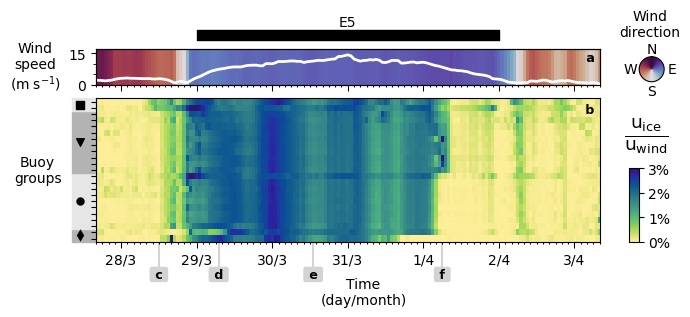

In [63]:

fig, axs = plt.subplots(2, 1, sharex=True, squeeze=True, 
                       gridspec_kw = {'height_ratios':[1,4]}, figsize=(6.5,2.5))



ax = axs[0]

#////////////////////
# wind direction ///
#/////////////////////////////////////////////////////////////////////////////////////

# plot params
#------------
ax.set_ylabel('Wind\nspeed\n($\mathrm{m\;s^{-1}}$)', rotation=0, labelpad=40, verticalalignment='center')
ax.set_xlim(XMIN, XMAX)
ax.xaxis.set_major_locator(plt.MultipleLocator(24))
ax.xaxis.set_minor_locator(plt.MultipleLocator(6))
ax.tick_params('x', length=4, width=0.75, which='major')
ax.tick_params('x', length=1.5, width=0.75, which='minor')

ax.set_yticks([])
ax.set_ylim(0,32)


mean_u10 = np.mean(u10_regrid, axis=0)
mean_v10 = np.mean(v10_regrid, axis=0)
dir_mean = metpy.calc.wind_direction(mean_u10*units('m/s'), mean_v10*units('m/s'), convention='from').magnitude


#------------------
# direction = dir_mean # local
# direction = wind_dir  # SBS region
direction = wdir_regrid[ordered_IDs.index('23'),:] # winds over buoy 23, near buoy array center
#------------------

winds = ax.pcolormesh(time_grid2, height_grid2*32, [direction],
                      vmin=0,vmax=360, cmap='twilight_shifted')

ax.text(1.1,1.7, 'Wind\ndirection', horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes)
add_windDir_key(fig.add_axes([0.93, 0.75, 0.1, 0.1], polar=True))


# label event
#------------
text_y = 1.65
event_y1 = 1.55
event_y0 = 1.25
open_y1 = 1.35
open_y0 = 1.1
    
ei = datetime(year = 2021, month=3, day=29, hour=0)
ef = datetime(year = 2021, month=4, day=2, hour=0)
ax.fill_between([ei, ef],  ax.get_ylim()[-1]*event_y0,ax.get_ylim()[-1]*event_y1,
            facecolor='k', edgecolor='k',alpha=1, zorder=-1, clip_on=False)
ax.text(ei+(ef-ei)/2, ax.get_ylim()[-1]*text_y, f'E5', 
        color='k',  horizontalalignment='center', clip_on=False)


# wind speed
#------------
ax2 = ax.twinx()

#------------------
# speed = np.mean(wind_regrid, axis=0) # local
# speed = wind_speed # SBS region
speed = wind_regrid[ordered_IDs.index('23'),:] # winds over buoy 23, near buoy array center
#------------------

ax2.plot(time, speed, c='white', lw=2)
ax2.set_ylim(0,17)
ax2.yaxis.set_major_locator(plt.MultipleLocator(15))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax2.yaxis.tick_left()
#/////////////////////////////////////////////////////////////////////////////////////



ax = axs[1]
    
#////////////////////
# plot colormesh ///
#/////////////////////////////////////////////////////////////////////////////////////
CMAP = cmocean.cm.haline_r#cmocean.tools.crop_by_percent(cmocean.cm.haline_r, 15, which='max', N=None)
mesh = ax.pcolormesh(time_grid, num_grid, speed_regrid/wind_regrid, vmin=0,vmax=3, cmap=CMAP)


ax.text(XMAX+timedelta(hours=15), 0.68*ax.get_ylim()[1], r'$\mathrm{\frac{u_{ice}}{u_{wind}}}$', 
    horizontalalignment='center',fontsize=FS+9, clip_on=False)
# ax.text(XMAX+timedelta(hours=25), 0.68*ax.get_ylim()[1], '(%)', 
#         horizontalalignment='center',clip_on=False)
# add_colorbar(fig, ax, [mesh], cb_placement='top', cb_width=0.03, 
#          cb_length_fraction=[1.03, 1.17], cb_pad=-0.275, cb_ticks=[0,1,2,3], 
#          cb_ticklabels='auto', cb_label = '',#'$\mathrm{cm\;{s}^{-1}}$',
#          labelpad='auto', cb_label_placement='bottom', cb_tick_placement='bottom',
#          cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])

add_colorbar(fig, ax, [mesh], cb_placement='right', cb_width=0.015, 
         cb_length_fraction=[0.0,0.525], cb_pad=0.045, cb_ticks=[0,1,2,3], 
         cb_ticklabels=['0%','1%','2%', '3%'], cb_label = '',#'$\mathrm{cm\;{s}^{-1}}$',
         labelpad='auto', cb_label_placement='right', cb_tick_placement='right',
         cb_labelsize=FS, draw_edges=False, edge_params=['k', 2])


# x ticks
#--------
ax.set_xticks(dates_to_label)
ax.set_xticklabels(date_labels)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1/12))
ax.tick_params('x', length=4, width=0.75, which='major')
ax.tick_params('x', length=1.5, width=0.75, which='minor')
ax.set_xlim(XMIN, XMAX)
# ax.set_xlabel('Time\n(day/month)', labelpad=10)
ax.text(datetime(2021,3,31,5), -10.5, 'Time\n(day/month)', horizontalalignment='center')

# y ticks
#--------
ax.set_ylim(-0.5,22.5)
ax.set_yticks(np.arange(len(ordered_IDs)))
ax.set_yticklabels(['']*len(ordered_IDs))
if str(dat_lab) == 'Mar29':
    ax.set_ylabel('Buoy\ngroups',rotation=0, labelpad=35, verticalalignment='center')
#/////////////////////////////////////////////////////////////////////////////////////



#////////////////////////
# plot group markers ///
#/////////////////////////////////////////////////////////////////////////////////////
marker_color = 'k'

B4 = 22.5
B3 = 20.5
B2 = 10.5
B1 = 1.5
B0 = -0.5

C1 = [0.7,0.7,0.7]
C2 = [0.9,0.9,0.9]


DT = timedelta(hours=7.5)
ax.fill_between([time[0]-DT, time[0]], [B0, B0], [B1, B1], color=C1, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B1, B1], [B2, B2], color=C2, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B2, B2], [B3, B3], color=C1, clip_on=False)
ax.fill_between([time[0]-DT, time[0]], [B3, B3], [B4, B4], color=C2, clip_on=False)

# for bound in [B1, B2, B3, B4]:
#     ax.hlines(bound, time[0]-DT, time[-1], lw = 1, colors='gray', linestyles='solid', clip_on=False)

DT = timedelta(hours=5)
ax.scatter(time[0]-DT, np.mean([B3,B4]), marker='s',c=marker_color,  s=30, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B2,B3]), marker='v',c=marker_color,  s=30, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B1,B2]), marker='o',c=marker_color,  s=25, clip_on=False)
ax.scatter(time[0]-DT, np.mean([B0,B1]), marker='d',c=marker_color,  s=40, clip_on=False, lw=0,)

    
#///////////////////////////
# label opening/closing ///
#/////////////////////////////////////////////////////////////////////////////////////
add_stars = [datetime(2021,3,28,12),datetime(2021,3,29,7),
             datetime(2021,3,30,13),datetime(2021,4,1,6)]
labels = [' c ',' d ',' e ',' f ']
for ll, loc in enumerate(add_stars):
#     ax.scatter(loc, ax.get_ylim()[0],  marker='x', facecolor='k', edgecolor='k',  
#                lw = 1.75, s=40, clip_on = False, zorder=4)
    ax.plot([add_stars[ll], add_stars[ll]], [ax.get_ylim()[0]-5.25, 0], c='lightgray', lw=1.5, 
            clip_on=False, zorder=-1)
    ax.text(loc, ax.get_ylim()[0]-5.25,  labels[ll], weight='bold',
            bbox=dict(facecolor='lightgray', edgecolor='None', boxstyle='round,pad=0.1,rounding_size=0.2'),
            color='k', size = 9, horizontalalignment='center', verticalalignment='center', 
            clip_on = False, zorder=4)

ax2.text(datetime(2021,4,3,5), 13,  ' a ', weight='bold',
            bbox=dict(facecolor='None', alpha=0.5, edgecolor='None', boxstyle='round,pad=0.1,rounding_size=0.2'),
            color='k', size = 9, horizontalalignment='center', verticalalignment='center', 
            clip_on = False, zorder=4)
axs[1].text(datetime(2021,4,3,5), 20.75,  ' b ', weight='bold',
            bbox=dict(facecolor='None', alpha=0.5, edgecolor='None', boxstyle='round,pad=0.1,rounding_size=0.2'),
            color='k', size = 9, horizontalalignment='center', verticalalignment='center', 
            clip_on = False, zorder=4)

fig.subplots_adjust(hspace=0.15)

# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigF/CASE{dat_lab}_IceSpeedRatio_v5.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=True, bbox_inches="tight", pad_inches = 0.05, dpi=500)

In [64]:
# buoys west of lead, but further west or north of lead than others
buoys_NW = ['24','53']
# buoys west of lead
buoys_W = ['29', '23', '41', '43', '38', '26', '40', '35', '25', '49']#'30',
# buoys east of lead
buoys_E = ['27','48', '46', '32', '36', '51', '50',  '33','45',]#'28',
# south and far east buoys that open later as different lead opens
buoys_SE = ['52', '31']

# Plot snapshots of daily conditions

### Pick date

In [65]:
all_imagery = {}


# Mar 29 info
date = datetime(year=2021, month=3, day=28, hour=12)
all_imagery[date] = {}

all_imagery[date]['mini_extent'] = [209.5,211,71.475,71.925]
all_imagery[date]['mid_extent'] = (-18208.94593864538, 36416.50519555687, -2086538.535386866, -2034793.4985611304)
all_imagery[date]['folder'] = '/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t1/'
all_imagery[date]['sensor'] = 'VIIRS'
all_imagery[date]['VMIN'] = 3.0
all_imagery[date]['VMAX'] = 4.3


# Mar 29 info
date = datetime(year=2021, month=3, day=29, hour=7)
all_imagery[date] = {}

all_imagery[date]['mini_extent'] = [209.5,211,71.475,71.925]
all_imagery[date]['mid_extent'] = (-18208.94593864538, 36416.50519555687, -2086538.535386866, -2034793.4985611304)
all_imagery[date]['folder'] = '/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t2/'
all_imagery[date]['sensor'] = 'MODIS'
all_imagery[date]['VMIN'] = 3.35
all_imagery[date]['VMAX'] = 4.6

# Mar 29 info
date = datetime(year=2021, month=3, day=30, hour=13)
all_imagery[date] = {}

all_imagery[date]['mini_extent'] = [209.5,211,71.475,71.925]
all_imagery[date]['mid_extent'] = (-18208.94593864538, 36416.50519555687, -2086538.535386866, -2034793.4985611304)
all_imagery[date]['folder'] = '/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t3/'
all_imagery[date]['sensor'] = 'VIIRS'
all_imagery[date]['VMIN'] = 3.2
all_imagery[date]['VMAX'] = 4.35

# Apr 1 info
date = datetime(year=2021, month=4, day=1, hour=6)
all_imagery[date] = {}

# all_imagery[date]['mini_extent'] = [208.,209.5,71.525,71.975]
# all_imagery[date]['mid_extent'] = (106209.72430539384, 163264.8296345141, -2078039.25532417, -2023127.5545928092)
all_imagery[date]['mini_extent'] = [208,209.65,71.475,72.05]
all_imagery[date]['mid_extent'] = (105760.75741944749, 169159.50643310702, -2083758.34997385, -2014153.4566151553)
all_imagery[date]['folder'] = '/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t4/'
all_imagery[date]['sensor'] = 'VIIRS'
all_imagery[date]['VMIN'] = 2.95
all_imagery[date]['VMAX'] = 4.15

# Apr 1 info
date = datetime(year=2021, month=4, day=2, hour=20)
all_imagery[date] = {}

all_imagery[date]['mini_extent'] = [208.,209.5,71.525,71.975]
all_imagery[date]['mid_extent'] = (106209.72430539384, 163264.8296345141, -2078039.25532417, -2023127.5545928092)
all_imagery[date]['folder'] = '/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t5/'
all_imagery[date]['sensor'] = 'VIIRS'
all_imagery[date]['VMIN'] = 3.5
all_imagery[date]['VMAX'] = 4.7


### functions for plotting

In [66]:
def add_background(ax):
#     ax.set_extent([203,213.2,70.8,73.1], crs=ccrs.PlateCarree())
#     ax.set_extent([202.8,214,70.6,73.4], crs=ccrs.PlateCarree())
#     ax.set_extent([202,234,70.7,71], crs=ccrs.PlateCarree())
#     ax.set_extent([202,229.5,70.8,70.82], crs=ccrs.PlateCarree())
#     ax.set_extent([219,233,70.1,70.15], crs=ccrs.PlateCarree())
    ax.set_extent([202.8,214,70.6,73.4], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')
    add_land(ax, scale='10m', color='lightgray')
    add_coast(ax, scale='10m', color='gray', linewidth=1, alpha=1, zorder=3)
#     add_grid(ax, lats=np.arange(70,72,0.5), lons=np.arange(190,214,1), 
#              linewidth=1, color='gray', alpha=0.5, zorder=100)

def plot_winds(ax, date, show_key=False):
    ds_era = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{date.year}.nc')
    ds_era.close()
    ds_era = ds_era.sel(time=date).sel(latitude=slice(90,60))
    ERAlons = ds_era.longitude.values
    ERAlons[ERAlons<0]+=360
    new_lon_ds = ds_era.assign_coords(longitude=ERAlons)
    ds_era = new_lon_ds.sortby('longitude').sel(longitude=slice(110,300))
    ERAlons = ds_era.longitude.values
    ERAlats = ds_era.latitude.values
    lons_era5,lats_era5 = np.meshgrid(ds_era.longitude.values,ds_era.latitude.values)
    u10 = ds_era.u10.values
    v10 = ds_era.v10.values
    
    # plot winds
    #-----------
    winds = ax.quiver(lons_era5,lats_era5, *fix_cartopy_vectors(u10,v10,lats_era5), 
                      scale=100, regrid_shape=6, headwidth=5, headlength=4, headaxislength=4,
                      width=0.005, color='gray', alpha=0.5, transform=ccrs.PlateCarree(), zorder=2)
    
    if show_key:
        key = ax.quiverkey(winds, X=1.15, Y=0.65, U=10, label = 'Wind\n10 $\mathrm{m\;{s}^{-1}}$', labelpos='N', fontproperties={'size':FS}, transform=ccrs.PlateCarree())
        key.set(zorder = 100)
        print('showkey!')
        
    return winds



def plot_buoys(ax, date, extent = 'mid', show_key=False):
    
    ds_era = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_2021.nc')
    ds_era.close()
    ERA_lons = ds_era.longitude.values
    ERA_lats = ds_era.latitude.values
    ERA_times = ds_era.time.values
            
    b_norm = matplotlib.colors.Normalize(vmin=0,vmax=3)
    b_cm = cmocean.cm.haline_r#cmocean.tools.crop_by_percent(cmocean.cm.haline_r, 20, which='max', N=None)

    dt = timedelta(hours=1)
    
    for buoy in buoy_IDs:
        lat_track = buoy_ds.latitude.sel(time=slice(date-dt, date+dt)).sel(buoyID = buoy).values
        lon_track = buoy_ds.longitude.sel(time=slice(date-dt, date+dt)).sel(buoyID = buoy).values
        time_track = pd.to_datetime(buoy_ds.time.sel(time=slice(date-dt, date+dt)).values)

        # find index of specified date 
        date_index = np.where(time_track == date)[0][0]

        lon_single = lon_track[date_index-1:date_index+2]
        lat_single = lat_track[date_index-1:date_index+2]
        time_single = time_track[date_index-1:date_index+2]

        # calculate velocity over hour centered around date
        u, v, time, dx, dy, dist = calc_velocity(lon_track=lon_single, lat_track=lat_single, 
                                                 time_track=time_single, step=2)
        
        # grab nearest wind
        #--------------------------------------------------------------------------------------
        tt = np.where(ERA_times == time_single[1])[0][0]
        spec_ds = ds_era.sel(time = ds_era.time[tt])
        
        if spec_ds.u10.dims == ('latitude', 'longitude'):
            all_u10 = np.transpose(spec_ds.u10.values)
            all_v10 = np.transpose(spec_ds.v10.values)
            all_msl = np.transpose(spec_ds.msl.values)
        else:
            all_u10 = spec_ds.u10.values
            all_v10 = spec_ds.v10.values
            all_msl = spec_ds.msl.values

        if ERA_lats[0] > ERA_lats[1]:
            ERA_lats_ = ERA_lats[::-1]
            all_u10_ = all_u10[:,::-1]
            all_v10_ = all_v10[:,::-1]
        else:
            ERA_lats_ = ERA_lats
            all_u10_ = all_u10
            all_v10_ = all_v10

        loc_u10, loc_v10 = interpolate_geo_data(interp_lon = lon_single[1], interp_lat = lat_single[1], 
                                                lons = ERA_lons, lats = ERA_lats_,
                                                data1 = all_u10_, data2 = all_v10_)
        local_wind = np.sqrt(loc_u10**2 + loc_v10**2)
        #--------------------------------------------------------------------------------------
        if str(extent) == 'mid':
            scale=200
            width=0.004
            
            if marker_dict[buoy]['group'] in ['NW', 'SE', 'LF'] or buoy in ['25','49']:
#                 S = 2 * marker_dict[buoy]['size']
#                 lw = 1
#                 S = 1 * marker_dict[buoy]['size']
#                 lw = 0.75
                S = 0.75 * marker_dict[buoy]['size']
                lw = 0.75

            else:
                S = 0.75 * marker_dict[buoy]['size']
                lw = 0.75

        else:
            scale=30
            width=0.0125
            
            S = 0.75 * marker_dict[buoy]['size']
            lw = 0.75

            
        # plot points

        drift_speed = np.sqrt(u.magnitude**2+v.magnitude**2)
        COLOR = b_cm(b_norm(drift_speed/local_wind))

        ax.scatter(np.array([lon_single[1]]), np.array([lat_single[1]]), 
                   facecolor=COLOR, edgecolor='k', lw=lw, marker = marker_dict[buoy]['shape'],
                   s = S, transform=ccrs.PlateCarree(), zorder=5)

        # plot drift vector from open_buoy_data / calc_velocity
        icevec = ax.quiver(np.array([lon_single[1]]), np.array([lat_single[1]]), 
                  *fix_cartopy_vectors(u.magnitude,v.magnitude,np.array([lat_single[1]])), 
                  scale=scale, width=width, headwidth=5, headlength=4, headaxislength=4,
                  color=[0.3,0.3,0.3], edgecolor='k', lw=0, alpha = 1, 
                  transform=ccrs.PlateCarree(), zorder=4)
    
    if show_key:
        key = ax.quiverkey(icevec, X=1.15, Y=0.2, U=20, 
                           label = 'Buoy\n20 $\mathrm{cm\;{s}^{-1}}$', labelpos='N', 
                           clip_on=False,
                           fontproperties={'size':FS}, transform=ccrs.PlateCarree())
        key.set(zorder = 100)
        print('showkey!')
        
        
#         if lon_single[1] < 0:
#             buoy_lon = lon_single[1]+360
#         else:
#             buoy_lon = lon_single[1]
            
#         oo, aa, dist =  nearest_ERAindices(lon = buoy_lon, lat = lat_single[1], 
#                                            ERA_lons = ERAlons, ERA_lats = ERAlats, refine = False)
#         spec_ds = ds_era.sel(latitude = ds_era.latitude[aa]).sel(longitude = ds_era.longitude[oo])
#         local_wind = np.sqrt(spec_ds.u10.values**2 + spec_ds.v10.values**2)
        
#         ds_era = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{date.year}.nc')
#         ds_era.close()
#         ds_era = ds_era.sel(time=date).sel(latitude=slice(90,60))

def plot_sat(ax, date):
    
#     cmap = mpl.cm.Greys(np.linspace(0,1,100))              # cropped cmap
#     ice_cmap = mpl.colors.ListedColormap(cmap[:-30,:-1]) # cropped cmap

#     ice_cmap = cmocean.tools.crop_by_percent(cmocean.cm.ice_r, 15, which='max', N=None)

#     ice_cmap = cmocean.cm.ice_r

#     ice_cmap = mpl.cm.bone_r
    
    ice_cmap = mpl.cm.Blues
    
    sensor = all_imagery[date]['sensor']
    SingleFolder = all_imagery[date]['folder']
    VMIN = all_imagery[date]['VMIN']
    VMAX = all_imagery[date]['VMAX']
    
    norm = matplotlib.colors.TwoSlopeNorm(vmin=VMIN, vcenter=VMIN + 0.8*(VMAX-VMIN), vmax=VMAX)
    
    print(SingleFolder)
    if str(sensor) == 'VIIRS':
        satellite_labels = [('VNP03MOD','VNP02MOD'), ('VJ103MOD','VJ102MOD')]
    elif str(sensor) == 'MODIS':
        satellite_labels = [('MOD03','MOD021KM'), ('MYD03','MYD021KM')]

    Image_Meta_paired = pair_images_meta(MainFolder = [], SingleFolder = SingleFolder, 
                                         sensor = sensor, 
                                         satellite_labels = satellite_labels,
                                         min_geofile_sizeMB = 28, min_imfile_sizeMB = 50, max_diff_minutes = 120)
    lat, lon, _image_ = grab_imagery_pair(Image_Meta_paired, sensor, pair = 0)

#     if date.date() == datetime(year=2021, month=4, day=17).date():
#         ax.pcolormesh(lon[1], lat[1], _image_[1], cmap=ice_cmap, norm=norm, #vmin = VMIN, vmax = VMAX, 
#                            shading='nearest', transform=ccrs.PlateCarree(),zorder=-1)
#         ax.pcolormesh(lon[0], lat[0], _image_[0], cmap=ice_cmap, vmin = 4.7, vmax = 5.35, 
#                        shading='nearest', transform=ccrs.PlateCarree(), zorder=-1)
#     else:
    ax.pcolormesh(lon[0], lat[0], _image_[0], cmap=ice_cmap, norm=norm,
                       shading='nearest', transform=ccrs.PlateCarree(), zorder=-1)
        
    if date.date() == datetime(year=2021, month=3, day=28).date():
        VMIN = 3.05
        VMAX = 4.1
        norm = matplotlib.colors.TwoSlopeNorm(vmin=VMIN, vcenter=VMIN + 0.8*(VMAX-VMIN), vmax=VMAX)
        ax.pcolormesh(lon[0], lat[0], ma.masked_where(lon[0]<207, _image_[0]), cmap=ice_cmap, norm=norm,
                      shading='nearest', transform=ccrs.PlateCarree(), zorder=-1)
    

0 < GeoAxes: <cartopy.crs.NorthPolarStereo object at 0x7fb1221110e0> > 2021-03-28 12:00:00
/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t1/
Search in single folder: /Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t1/
Pair 0
------
2021-03-28 12:48:00



/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


1 < GeoAxes: <cartopy.crs.NorthPolarStereo object at 0x7fb1221110e0> > 2021-03-30 13:00:00
/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t3/
Search in single folder: /Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t3/
Pair 0
------
2021-03-30 13:00:00



/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


showkey!
showkey!
2 < GeoAxes: <cartopy.crs.NorthPolarStereo object at 0x7fb1221110e0> > 2021-03-29 07:00:00
/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t2/
Search in single folder: /Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t2/
Pair 0
------
2021-03-29 07:10:00



/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


3 < GeoAxes: <cartopy.crs.NorthPolarStereo object at 0x7fb1221110e0> > 2021-04-01 06:00:00
/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t4/
Search in single folder: /Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t4/
Pair 0
------
2021-04-02 13:42:00



/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


(105760.75741944749, 169159.50643310702, -2083758.34997385, -2014153.4566151553)
/Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t4/
Search in single folder: /Volumes/Jewell_EasyStore/SIDEx2021/Event_Mar29/t4/
Pair 0
------
2021-04-02 13:42:00



/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


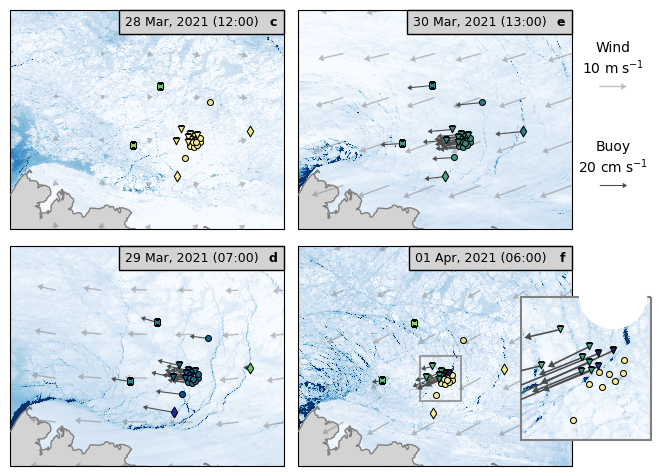

In [75]:
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# dates = [datetime(2021,3,29,6,0),
#          datetime(2021,4,16,6,0), 
#          datetime(2021,4,1,6,0), 
#          datetime(2021,4,17,0,0)]

dates = [datetime(year=2021, month=3, day=28, hour=12),
         datetime(year=2021, month=3, day=30, hour=13),
        datetime(year=2021, month=3, day=29, hour=7),
         datetime(year=2021, month=4, day=1, hour=6)]


# create figure
#--------------
fig = plt.figure(figsize=(7.25,6))
gs = GridSpec(2,2, width_ratios=[1,1], height_ratios=[1,1])
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
ax0 = fig.add_subplot(gs[0], projection=map_projection)
ax1 = fig.add_subplot(gs[1], projection=map_projection)
ax2 = fig.add_subplot(gs[2], projection=map_projection)
ax3 = fig.add_subplot(gs[3], projection=map_projection)
axs = [ax0, ax1, ax2, ax3]

labels = ['c', 'e', 'd', 'f']

for aa, ax in enumerate(axs):
    
    date = dates[aa]
    print(aa, ax, date)
    
    add_background(ax)
    
    # plot satellite imagery
    #-------------------------------
    plot_sat(ax, date)
    
    # plot winds and buoys from date
    #-------------------------------
    if aa == 1:
        show_key = True
    else:
        show_key = False
    plot_winds(ax, date, show_key=show_key)
    plot_buoys(ax, date, show_key=show_key)


    # label date and panel
    #-------------------------------
    ax.text(0.98, 0.945, date.strftime('%d %b, %Y (%H:%M)     '),#+f'{labels[aa]}',
            bbox=dict(facecolor='lightgray', edgecolor='k'),#, boxstyle='round,pad=0.25,rounding_size=0.2'),
            color='k', size = 9, horizontalalignment='right', verticalalignment='center', 
            transform=ax.transAxes, zorder=100, clip_on=False)
    ax.text(0.975, 0.945, f'{labels[aa]}', weight='bold', 
            size = 9, horizontalalignment='right', verticalalignment='center', 
            transform=ax.transAxes, zorder=100, clip_on=False)
#     ax.scatter(0.96, 0.945,  facecolor='k', edgecolor='k', lw=1.5,
#                marker = 'x', s = 90, transform=ax.transAxes, zorder=100, clip_on=False)

    
    
    if date == datetime(year=2021, month=4, day=1, hour=6):
        # polygons
        #-------------------------------
        # outline midsize region
        mid_extent = all_imagery[date]['mid_extent'] 
        ax.plot([mid_extent[0],mid_extent[0],mid_extent[1],mid_extent[1],mid_extent[0]], 
                [mid_extent[2],mid_extent[3],mid_extent[3],mid_extent[2],mid_extent[2]], 
                c='gray', lw=1.5, alpha=0.75,zorder=1)

        # create inset plots
        #-------------------
        axins = inset_axes(ax, width="100%", height="100%", loc='upper left',
#                            bbox_to_anchor=(-0.065,1.01-0.5,.5,.5), bbox_transform=ax.transAxes, 
                           bbox_to_anchor=(0.7,0.8-0.65,.65,.65), bbox_transform=ax.transAxes, 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=map_projection))
        # create figure
        #--------------
        axins.set_extent(all_imagery[date]['mini_extent'], crs=ccrs.PlateCarree())
        print(axins.get_extent())
        axins.spines['geo'].set_edgecolor('gray')
        axins.spines['geo'].set_linewidth(1.5)

        # plot satellite imagery
        plot_sat(axins, date)
        plot_buoys(axins, date, extent = 'mini', show_key=False)


#     sp=20
#     if date.date() == datetime(year=2021, month=4, day=17).date():
#         ax.pcolormesh(lon[1][::sp,::sp], lat[1][::sp,::sp], _image_[1][::sp,::sp], cmap=ice_cmap, vmin = VMIN, vmax = VMAX, 
#                        shading='nearest', transform=ccrs.PlateCarree(),zorder=-1)
#         ax.pcolormesh(lon[0][::sp,::sp], lat[0][::sp,::sp], _image_[0][::sp,::sp], cmap=ice_cmap, vmin = 4.7, vmax = 5.35, 
#                        shading='nearest', transform=ccrs.PlateCarree(), zorder=-1)
#     else:
#         ax.pcolormesh(lon[0][::sp,::sp], lat[0][::sp,::sp], _image_[0][::sp,::sp], cmap=ice_cmap, vmin = VMIN, vmax = VMAX, 
#                        shading='nearest', transform=ccrs.PlateCarree(), zorder=-1)
    
# add hidden plot on right to expand figure so wuiver key displays
axins = inset_axes(ax1, width="100%", height="100%", loc='upper left',
                    bbox_to_anchor=(1.0,1.01-0.4,.25,.4), bbox_transform=ax.transAxes, 
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=map_projection))
axins.spines['geo'].set_edgecolor('None')



# gs.update(wspace=0.1, hspace=0.0)
gs.update(wspace=0.05, hspace=0.05)
plt.show()


# save figure
# ------------   
# savename = f"./figures/KeyFigs/FigF/case_Mar29_v1.png"
# print(f'>>> save as: {savename}')
# fig.savefig(savename, 
#             transparent=True, bbox_inches="tight", pad_inches = 0.1, dpi=600)
